--- Loaded Data (first 5 rows) ---
   wavelength    efficiency
0    0.931000  2.191901e-09
1    0.931135  1.828837e-09
2    0.931270  9.193326e-10
3    0.931405  4.997221e-10
4    0.931541  1.075342e-09

--- Data Types ---
wavelength    float64
efficiency    float64
dtype: object


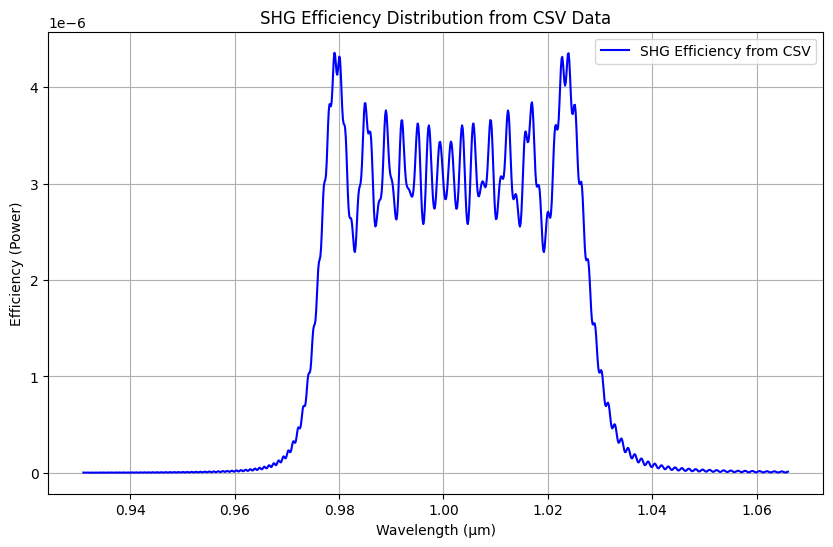

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # 必要に応じて数値計算用

# --- CSVファイルの読み込み ---
# CSVファイル名を指定（前のスクリプトで出力したファイル名）
csv_filename = 'chirped_shg_efficiency.csv'

# pandasを使ってCSVファイルを読み込む
# header=0 は1行目をヘッダーとして認識させるため（デフォルト）
# encoding='utf-8' は前のスクリプトで指定したエンコーディングに合わせる
df_data = pd.read_csv(csv_filename, header=0, encoding='utf-8')

# データの確認（最初の数行を表示）
print("--- Loaded Data (first 5 rows) ---")
print(df_data.head())
print("\n--- Data Types ---")
print(df_data.dtypes)  # 各列のデータ型を確認

# --- データの抽出 ---
# CSVファイルの列名に合わせてデータを抽出
wavelength_column_name = 'wavelength'
efficiency_column_name = 'efficiency'

if wavelength_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{wavelength_column_name}' not found in {csv_filename}")
if efficiency_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{efficiency_column_name}' not found in {csv_filename}")

wavelengths_loaded = df_data[wavelength_column_name].values
efficiency_loaded = df_data[efficiency_column_name].values

# --- Matplotlibでプロット ---
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# データをプロット
plt.plot(wavelengths_loaded, efficiency_loaded,  # type: ignore
         color='blue', label='SHG Efficiency from CSV')

# グラフの装飾
plt.xlabel("Wavelength (μm)")  # X軸ラベル
plt.ylabel("Efficiency (Power)")       # Y軸ラベル
plt.title("SHG Efficiency Distribution from CSV Data")  # グラフタイトル
plt.legend()      # 凡例を表示
plt.grid(True)    # グリッドを表示

# 必要に応じてY軸の範囲などを調整
# plt.ylim(0, max(efficiency_loaded) * 1.1) # 例: Y軸の最小値を0、最大値をデータの最大値の1.1倍に

# グラフを表示
plt.show()

In [ ]:
# TODO: 5種類の周期分極反転構造をくっつけたもの、それぞれ1000ドメインずつで合計5000ドメイン、各構造でduty比と周期が異なり、合計10種類のパラメータ
# TODO: 5000ドメインだと0.5秒くらいで分布が計算できるので、オプティマイザでその計算を繰り返して、10個のパラメータを決定すればいけそう